In [1]:
import pandas as pd

import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import seaborn as sn

import random
import os

In [2]:
sequence_path = "../chr_seq/"
annotation_path = "../combined_annotations.csv"

In [3]:
annotations = pd.read_csv(annotation_path, sep='\t')

In [4]:
annotations['label'] = annotations['label'].replace('junk', 'non-target')

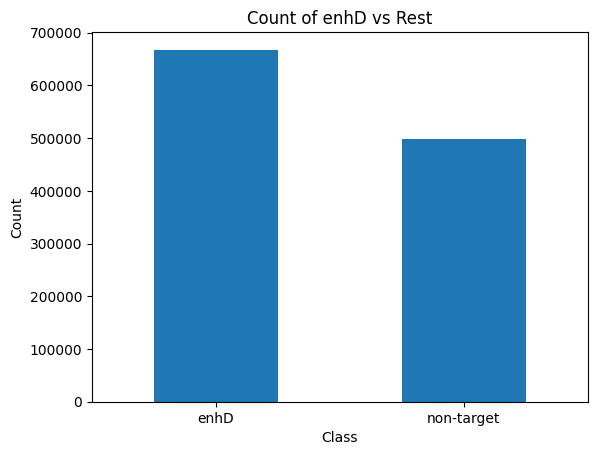

In [5]:
# # Count the occurrences of each class
# class_counts = annotations['label'].value_counts()
# class_counts['rest'] = class_counts.drop('enhD').sum()
# class_counts = class_counts[['enhD', 'rest']]

# # Plot the counts
# class_counts.plot(kind='bar')
# plt.title('Count of enhD vs Rest')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
# plt.show()

class_counts = annotations['label'].value_counts()
class_counts = class_counts[['enhD', 'non-target']]

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhD vs Rest')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()



In [6]:
annotations=annotations[annotations['label'].isin(['enhD', 'non-target'])]

In [7]:
# Count the number of 'prom' annotations
num_nt = len(annotations[annotations['label'] == 'non-target'])

# Randomly sample 'non-target' annotations to match the number of 'prom' annotations
enh_annotations_sampled = annotations[annotations['label'] == 'enhD'].sample(n=num_nt, random_state=42)

# Combine the two sets
annotations = pd.concat([annotations[annotations['label'] == 'non-target'], enh_annotations_sampled])

# Now you can proceed to create your dataset with 'balanced_annotations'
# instead of the full 'annotations' DataFrame

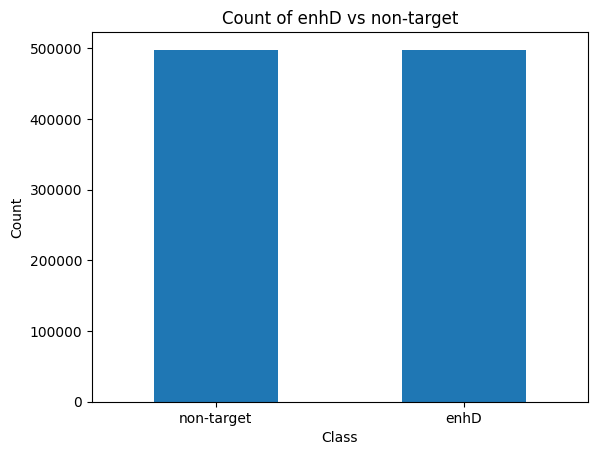

In [8]:
class_counts = annotations['label'].value_counts()

# Plot the counts
class_counts.plot(kind='bar')
plt.title('Count of enhD vs non-target')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels to show them horizontally
plt.show()


In [9]:
annotations.head()

,chrom,frameStart,frameEnd,label
1,chr1,182069,182469,non-target
3,chr1,701385,701785,non-target
7,chr1,781366,781766,non-target
9,chr1,799741,800141,non-target
11,chr1,811198,811598,non-target


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd


class DNADataset(Dataset):
    def __init__(self, sequence, annotations, encoding_type='integer'):
        self.sequence = sequence
        self.annotations = annotations
        self.encoding_type = encoding_type
        self.sections = self._extract_sections()
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):     
        start, end, label = self.sections[index]
        sequence_section = self.sequence[start:end]
        sequence_section = [self._map_dna_letter(letter) for letter in sequence_section]
        sequence_section = torch.tensor(sequence_section).T
        
        return sequence_section, label
    
    def _extract_sections(self):
        sections = []
        # Iterate over each annotation
        for _, row in self.annotations.iterrows():
            start = row['frameStart']
            end = row['frameEnd']
            label = self._map_annotation_type(row['label'])
            sections.append((start, end, label))
        return sections

    def _map_dna_letter(self, letter):
        if self.encoding_type == 'integer':
            if letter == 'A':
                return 1
            elif letter == 'C':
                return 2
            elif letter == 'G':
                return 3
            elif letter == 'T':
                return 4
            elif letter == 'N':
                return 5
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        elif self.encoding_type == 'one_hot':
            if letter == 'A':
                return [1, 0, 0, 0]
            elif letter == 'C':
                return [0, 1, 0, 0]
            elif letter == 'G':
                return [0, 0, 1, 0]
            elif letter == 'T':
                return [0, 0, 0, 1]
            elif letter == 'N':
                return [0, 0, 0, 0]
            else:
                raise ValueError(f"Invalid DNA letter: {letter}")
        else:
            raise ValueError(f"Invalid encoding type: {self.encoding_type}")
    
    @staticmethod
    def _map_annotation_type(annotation_type):
        if annotation_type == 'enhD':
            return 1
        elif annotation_type == 'non-target':
            return 0

In [11]:
# Create a list of chromosome names including chrX and chrY
chr_sequences = [f'chr{i}' for i in range(1, 23)] + ['chrX', 'chrY']

dataset = []

for seq in chr_sequences:
    # Read DNA sequence file
    print(f'Processing {seq}...')
    sequence_file_path = f'{sequence_path}/{seq}.fa'
    annotations_for_seq = annotations[annotations['chrom'] == seq]
    print(f'Number of annotations for {seq}: {annotations_for_seq.shape[0]}')
    
    with open(sequence_file_path, 'r') as file:
        # Skip the first line which is the header
        next(file)
        # Read the sequence, remove newlines and convert to uppercase
        dna_sequence = file.read().replace("\n", "").upper()
        
        # Initialize the dataset for this chromosome with its annotations
        ds = DNADataset(dna_sequence, annotations_for_seq, encoding_type='one_hot')
        # Extend the main dataset with the data from this chromosome
        dataset.extend(ds)

# Split into training and testing sets (adjust ratios as per your needs)
train_size = int(0.9 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])



Processing chr1...
Number of annotations for chr1: 87907
Processing chr2...
Number of annotations for chr2: 85294
Processing chr3...
Number of annotations for chr3: 69422
Processing chr4...
Number of annotations for chr4: 53836
Processing chr5...
Number of annotations for chr5: 59105
Processing chr6...
Number of annotations for chr6: 60803
Processing chr7...
Number of annotations for chr7: 53244
Processing chr8...
Number of annotations for chr8: 49279
Processing chr9...
Number of annotations for chr9: 42327
Processing chr10...
Number of annotations for chr10: 50070
Processing chr11...
Number of annotations for chr11: 47549
Processing chr12...
Number of annotations for chr12: 48692
Processing chr13...
Number of annotations for chr13: 29681
Processing chr14...
Number of annotations for chr14: 31943
Processing chr15...
Number of annotations for chr15: 31429
Processing chr16...
Number of annotations for chr16: 29790
Processing chr17...
Number of annotations for chr17: 35587
Processing chr1

In [12]:
# # Save datasets
# torch.save(train_dataset, 'train_dataset.pt')
# torch.save(test_dataset, 'test_dataset.pt')


In [13]:
# train_dataset = torch.load('train_dataset.pt')
# test_dataset = torch.load('test_dataset.pt')

In [14]:
train_dataset.__len__()

895928

In [15]:
print(train_dataset.__getitem__(1))

(tensor([[1, 0, 1,  ..., 0, 0, 1],
        [0, 1, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]]), 0)


In [16]:
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv1d(4, 32, kernel_size=3, stride=1, padding=1)
#         self.pool1 = nn.MaxPool1d(kernel_size=2)
#         self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)
#         self.pool2 = nn.MaxPool1d(kernel_size=2)
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(32 * 100, 100)
#         self.dropout = nn.Dropout(0.8)
#         self.fc2 = nn.Linear(100, 50)
#         self.fc3 = nn.Linear(50, 2)
#         # self.softmax = nn.Softmax(dim=1)

    
#     def forward(self, x):
#         x = self.pool1(nn.functional.relu(self.conv1(x)))
#         x = self.pool2(nn.functional.relu(self.conv2(x)))
#         x = self.flatten(x)
#         x = nn.functional.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
#         # x = self.softmax(x)
#         return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 50, 128)  # Assuming max pooling is applied 3 times
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(self.dropout(x)))
        x = nn.functional.relu(self.fc2(self.dropout(x)))
        x = self.fc3(x)
        return x


In [17]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the training parameters
batch_size = 1024
num_epochs = 20
learning_rate = 0.0001

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




In [18]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device


device(type='cpu')

Epoch 1/20:
Train Loss: 0.6631, Train Accuracy: 0.5873
Test Loss: 0.6358, Test Accuracy: 0.6296
ROC AUC: 0.6890

Epoch 2/20:
Train Loss: 0.6268, Train Accuracy: 0.6487
Test Loss: 0.6142, Test Accuracy: 0.6623
ROC AUC: 0.7212

Epoch 3/20:
Train Loss: 0.6144, Train Accuracy: 0.6617
Test Loss: 0.6064, Test Accuracy: 0.6685
ROC AUC: 0.7304

Epoch 4/20:
Train Loss: 0.6083, Train Accuracy: 0.6672
Test Loss: 0.6005, Test Accuracy: 0.6750
ROC AUC: 0.7358

Epoch 5/20:
Train Loss: 0.6040, Train Accuracy: 0.6710
Test Loss: 0.5968, Test Accuracy: 0.6775
ROC AUC: 0.7396

Epoch 6/20:
Train Loss: 0.6012, Train Accuracy: 0.6734
Test Loss: 0.5942, Test Accuracy: 0.6793
ROC AUC: 0.7423

Epoch 7/20:
Train Loss: 0.5986, Train Accuracy: 0.6755
Test Loss: 0.5923, Test Accuracy: 0.6806
ROC AUC: 0.7446

Epoch 8/20:
Train Loss: 0.5968, Train Accuracy: 0.6769
Test Loss: 0.5917, Test Accuracy: 0.6805
ROC AUC: 0.7464

Epoch 9/20:
Train Loss: 0.5949, Train Accuracy: 0.6786
Test Loss: 0.5890, Test Accuracy: 0.6826


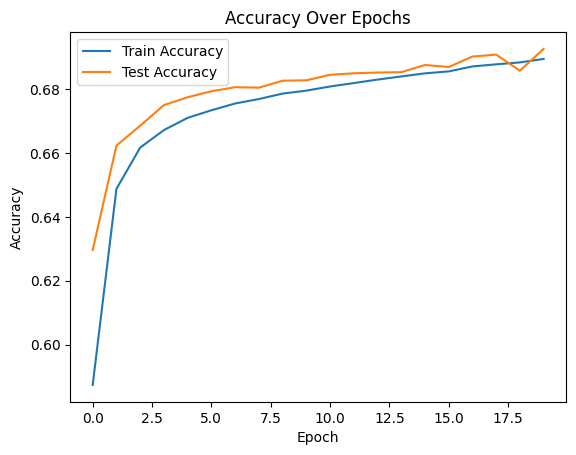

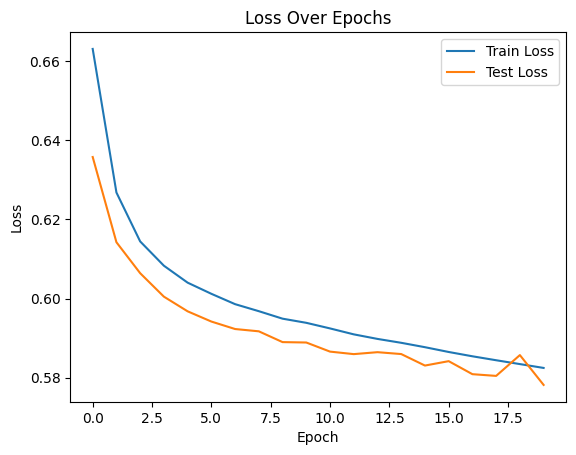

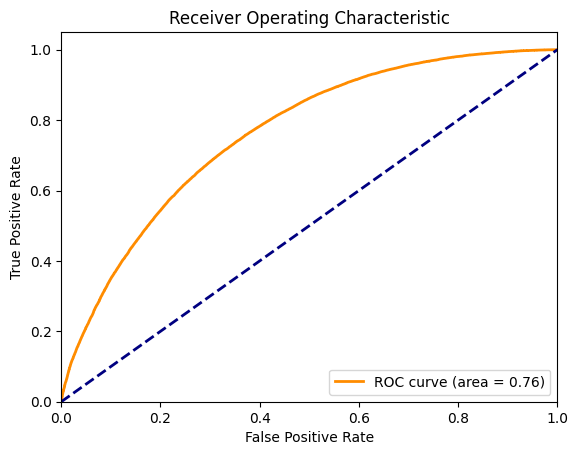

In [19]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
# # Training loop
# for epoch in range(num_epochs):
#     model.train()  # Set the model to train mode
#     total_loss = 0.0
#     correct_predictions = 0

#     for inputs, labels in train_loader:
#         optimizer.zero_grad()  # Zero the gradients

#         # Convert data types
#         inputs = inputs.float()
#         labels = labels.long()

#         # Forward pass
#         outputs = model(inputs)

#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#         # Track training loss and accuracy
#         total_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs.data, 1)
#         correct_predictions += (predicted == labels).sum().item()

#     # Calculate average loss and accuracy for the epoch
#     avg_loss = total_loss / len(train_dataset)
#     accuracy = correct_predictions / len(train_dataset)

#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

Test Loss: 0.5782, Test Accuracy: 0.6926


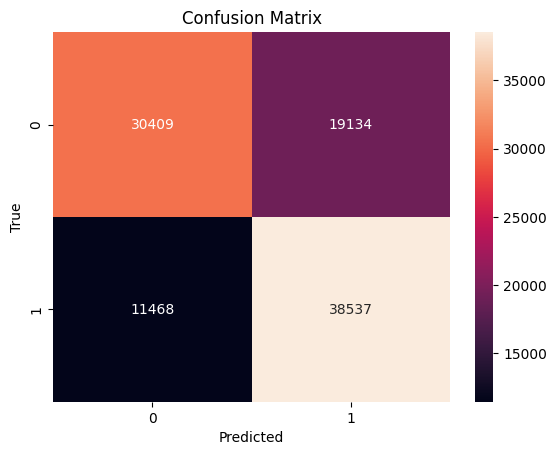

              precision    recall  f1-score   support

           0       0.73      0.61      0.67     49543
           1       0.67      0.77      0.72     50005

    accuracy                           0.69     99548
   macro avg       0.70      0.69      0.69     99548
weighted avg       0.70      0.69      0.69     99548



In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.



In [22]:
class_counts

label
non-target    497738
enhD          497738
Name: count, dtype: int64

In [23]:
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.rnn = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64,2)
        self.pool = nn.MaxPool1d(2, 2)    
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.permute(0,2,1)
        x, (hn, cn) = self.rnn(x)
        x = hn[-1,:,:]
        x = self.fc(x)
        return x


Epoch 1/20:
Train Loss: 0.6861, Train Accuracy: 0.5338
Test Loss: 0.6585, Test Accuracy: 0.6005
ROC AUC: 0.6419

Epoch 2/20:
Train Loss: 0.6455, Train Accuracy: 0.6274
Test Loss: 0.6359, Test Accuracy: 0.6422
ROC AUC: 0.6867

Epoch 3/20:
Train Loss: 0.6304, Train Accuracy: 0.6440
Test Loss: 0.6340, Test Accuracy: 0.6402
ROC AUC: 0.7021

Epoch 4/20:
Train Loss: 0.6213, Train Accuracy: 0.6539
Test Loss: 0.6188, Test Accuracy: 0.6579
ROC AUC: 0.7123

Epoch 5/20:
Train Loss: 0.6175, Train Accuracy: 0.6578
Test Loss: 0.6149, Test Accuracy: 0.6607
ROC AUC: 0.7173

Epoch 6/20:
Train Loss: 0.6141, Train Accuracy: 0.6611
Test Loss: 0.6130, Test Accuracy: 0.6622
ROC AUC: 0.7217

Epoch 7/20:
Train Loss: 0.6112, Train Accuracy: 0.6640
Test Loss: 0.6091, Test Accuracy: 0.6668
ROC AUC: 0.7252

Epoch 8/20:
Train Loss: 0.6088, Train Accuracy: 0.6662
Test Loss: 0.6085, Test Accuracy: 0.6655
ROC AUC: 0.7282

Epoch 9/20:
Train Loss: 0.6070, Train Accuracy: 0.6676
Test Loss: 0.6047, Test Accuracy: 0.6707


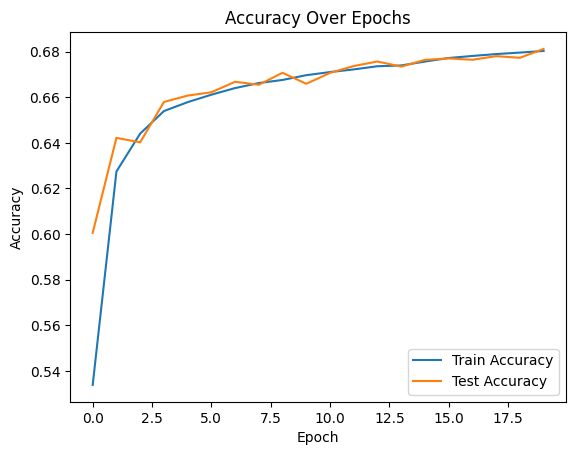

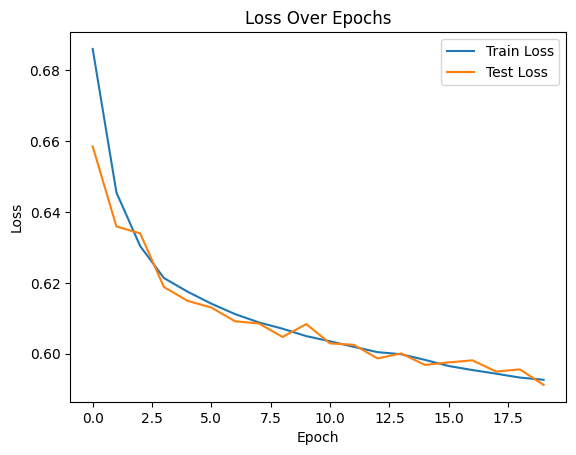

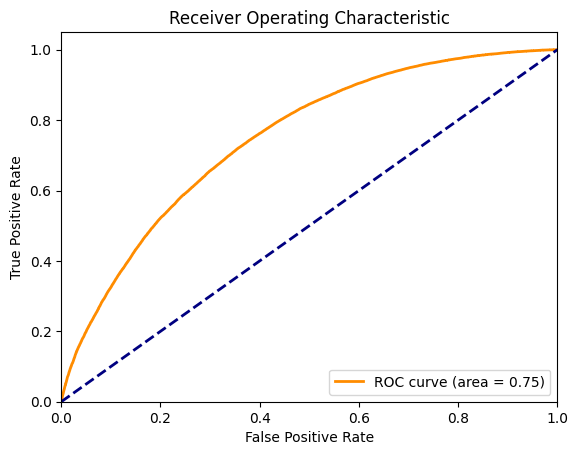

In [24]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Create an instance of the CNN model
model = CRNN()
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_losses_per_epoch, train_accuracies_per_epoch = [], []
test_losses_per_epoch, test_accuracies_per_epoch = [], []
fpr_list, tpr_list, roc_auc_list = [], [], []  # For ROC curves

# Adjusted training loop
for epoch in range(num_epochs):
    model.train()
    total_loss, correct_predictions = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_accuracy = correct_predictions / len(train_loader.dataset)
    train_losses_per_epoch.append(avg_train_loss)
    train_accuracies_per_epoch.append(train_accuracy)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_loss, correct_predictions, all_targets, all_probabilities = 0, 0, [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

            # For ROC curve
            probabilities = nn.functional.softmax(outputs, dim=1)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

    avg_test_loss = total_loss / len(test_loader.dataset)
    test_accuracy = correct_predictions / len(test_loader.dataset)
    test_losses_per_epoch.append(avg_test_loss)
    test_accuracies_per_epoch.append(test_accuracy)

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(all_targets, all_probabilities)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}\n")

# Plot training and test accuracies
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(test_accuracies_per_epoch, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Plot training and test losses
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(test_losses_per_epoch, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# Plot the ROC curve (using the last epoch's data)
plt.plot(fpr_list[-1], tpr_list[-1], color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_list[-1]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Test Loss: 0.5912, Test Accuracy: 0.6812


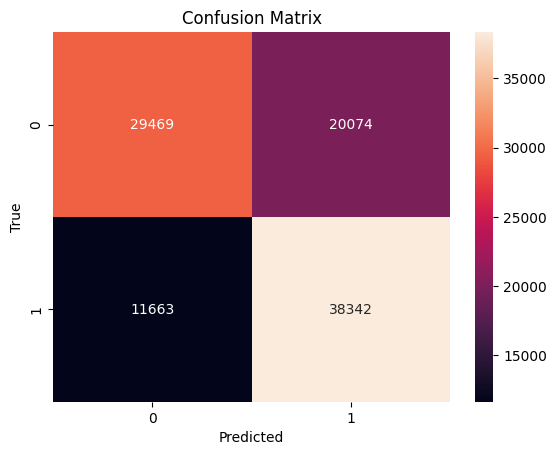

              precision    recall  f1-score   support

           0       0.72      0.59      0.65     49543
           1       0.66      0.77      0.71     50005

    accuracy                           0.68     99548
   macro avg       0.69      0.68      0.68     99548
weighted avg       0.69      0.68      0.68     99548



In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()  # Set the model to evaluation mode
total_loss = 0.0
correct_predictions = 0
all_predicted_labels = []
all_true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.float().to(device), labels.long().to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        
        all_true_labels.extend(labels.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

avg_loss = total_loss / len(test_loader.dataset)
accuracy = correct_predictions / len(test_loader.dataset)
# test_losses.append(avg_loss)
# test_accuracies.append(accuracy)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Confusion matrix
confusion_mtx = confusion_matrix(all_true_labels, all_predicted_labels)
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(all_true_labels, all_predicted_labels))

# Suggestions for further improvements in elegance:
# 1. Function Definitions: Consider defining functions for repetitive tasks like plotting or calculating metrics.
# 2. Early Stopping: Implement early stopping during training to prevent overfitting.
# 3. Logging: Use a logging library instead of print statements for better control over the logging level and formatting.

